## Import modules/scripts and optimize portfolio weights:

In [15]:
from datetime import date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np
import torch

from JSONReader import read_json
from cov_matrix import MPTCovMat
from allocator import WeightOptimizer
from backtesting import BackTester

### Set desired parameters

In [16]:
# ---------- OPTIMIZATION ----------
train_start = date(2022,1,1)
train_end = date(2023,12,31)

#loss function:
alpha = 0.3 #calmar
beta = 0.1 #omega
gamma = 0.6 #sortino

#target:
rf = 0.027 #risk free rate (can be used as target rate instead)
rf_period = timedelta(120) #number of days for risk free, e.g. 365 for annual 

num_iter = 10000 #number of weight update iterations
weight_decay = 0.1 #affects distribution of weights - higher value will lead to more even distribution

# ---------- COMPARISON ---------- 
test_start=date(2024,1,1)
test_end=date(2024,12,31 )
comparison_ticker = '^OMX' #ticker of index to compare against


### Optimize weights

In [17]:
ticker_list = read_json('assets.json')
tickers = yf.Tickers(ticker_list)

#get data
data = MPTCovMat(tickers=tickers,start=train_start,end=train_end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

allocator = WeightOptimizer(lr=1e-3,num_assets=len(asset_names),risk_free=rf,risk_free_period=rf_period,num_iter=num_iter, weight_decay=weight_decay)
cos_losses, pf_daily_returns = allocator.optimize_weights(alpha,beta,gamma, returns=torch.tensor(returns.values))
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Optimizing weights... 
Ticker
ABB.ST          6.273335
ALFA.ST         3.532537
ASSA-B.ST       2.276299
ATCO-A.ST       3.072160
ATCO-B.ST       1.429593
AZN.ST          2.207603
BOL.ST          1.024389
ELUX-B.ST       0.390126
ERIC-B.ST       0.712364
ESSITY-B.ST     0.606792
EVO.ST          1.455108
GETI-B.ST       0.530292
HEXA-B.ST       0.750330
HM-B.ST         4.217656
INVE-B.ST      36.984547
KINV-B.ST       0.082518
NDA-SE.ST       0.213350
NIBE-B.ST       0.408462
SAAB-B.ST      16.077038
SAND.ST         0.186777
SBB-B.ST        0.653060
SCA-B.ST        1.192594
SEB-A.ST        2.999807
SHB-A.ST        3.256579
SINCH.ST        0.955784
SKF-B.ST        1.065225
SWED-A.ST       0.840219
TEL2-B.ST       0.862689
TELIA.ST        1.148528
VOLV-B.ST       4.594235
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

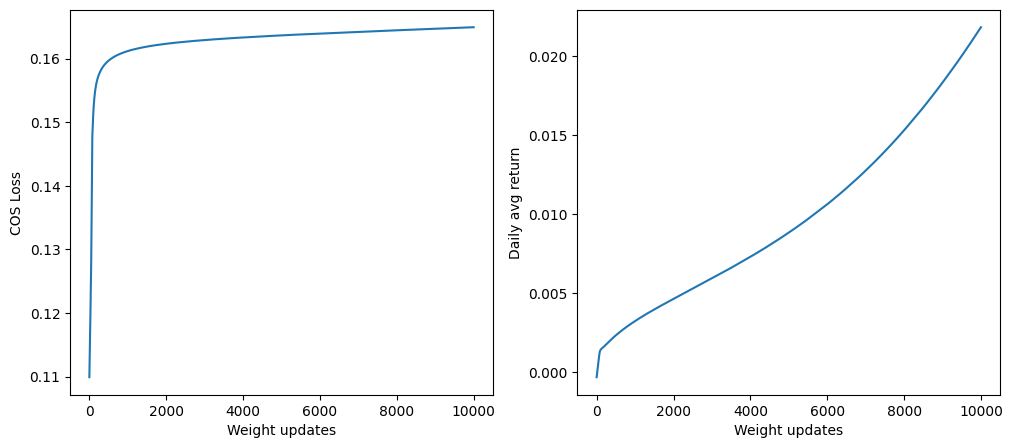

In [18]:
x_df = pd.DataFrame(range(0,num_iter))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(x_df,cos_losses.numpy(force=True),)
ax1.set_xlabel('Weight updates')
ax1.set_ylabel('COS Loss')
ax2.plot(x_df,pf_daily_returns.numpy(force=True),)
ax2.set_xlabel('Weight updates')
ax2.set_ylabel('Daily avg return')
plt.show()

## Backtesting

### Get comparison data

In [19]:
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
comp_data = yf.Ticker(comparison_ticker).history(start=test_start,end=test_end,auto_adjust=True)
comp_returns:pd.DataFrame = np.log(comp_data['Close']/comp_data['Close'].shift(1))
comp_returns.dropna(inplace=True)
comp_cumulative = (comp_returns+1).cumprod(0)-1

[*********************100%***********************]  30 of 30 completed

TESTING


### Plot  results

Comparison portfolio return: 2.88 %
Optimized portfolio return: 23.24 %
Percentage point difference: 20.36 pp
Percentage difference: 706.94 %


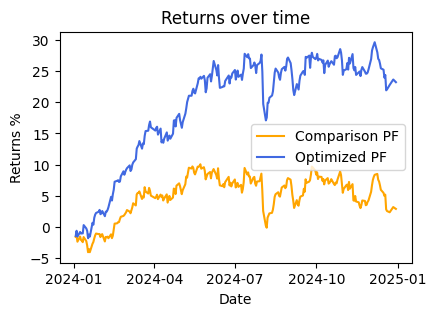

In [20]:
comp_returns = pd.DataFrame(comp_cumulative)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=6))
ax1.plot(comp_returns.mul(100),color='orange')
ax1.plot(test_returns.mul(100),color='royalblue')
ax1.legend(['Comparison PF','Optimized PF'])
comp_final_return = round((comp_returns.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_returns.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')